In [1]:
import copy
import h5py
import itertools
import numpy as np
import scipy
import scipy.interpolate
import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import palettable

In [20]:
import kalepy as kale
import verdict

In [22]:
import yt
import trident
import unyt as u

# Parameters

In [5]:
seed = 15482
rng = np.random.default_rng( seed )

In [6]:
distribution_fp = './data/EAGLE/histogram_galaxies_logM200c-Msun-12.0-12.5_200_seed0_hneutralssh.hdf5'

In [7]:
n_sightlines = 100
min_clouds_per_sightline = 1
max_clouds_per_sightline = 3
velocity_range = [ -150., 150. ] # In km/s

In [ ]:
ions = [ 'H I', 'O I', 'C II', 'C III', 'N II', 'N III', 'Si II', 'Si III', 'Si IV', 'N V', 'O VI', 'Mg II' ]
fields = [
    'H_p0_number_density', 
    'O_p0_number_density',
    'C_p1_number_density',
    'C_p2_number_density',
    'N_p1_number_density',
    'N_p2_number_density',
    'Si_p1_number_density',
    'Si_p2_number_density',
    'Si_p3_number_density',
    'N_p4_number_density',
    'O_p5_number_density',
    'Mg_p1_number_density',
]

# Load and Format Data

Units are [ g/cm^3, mass fraction, logK, log cm^-2 ] respectively for ['Density', 'Metallicity', 'Temperature', 'hneutralssh'].

In [8]:
f = h5py.File( distribution_fp, 'r' )

In [9]:
# Get centers, reformat edges

histogram_axes = [ 'Temperature', 'Density', 'Metallicity', 'hneutralssh' ]
centers = []
bins = []
dxs = []
for i, key in enumerate( histogram_axes ):
    
    arr = copy.copy( f['histogram_axes'][key][...] )
    dx = arr[2] - arr[1]
    
    # For convenience, let's not have a -inf edge lying around
    if key == 'Metallicity':
        arr[0] = arr[1] - dx
        
    centers_i = arr[:-1] + 0.5 * dx
    
    dxs.append( dx )
    centers.append( centers_i )
    bins.append( arr )

In [10]:
# Normalize into a pdf

norm = f['histogram'][...].sum() * dxs[0] * dxs[1] * dxs[2] * dxs[3]
pdf = f['histogram'][...] / norm

## Construct Ways to Sample the Distribution

In [11]:
# Create a Kernel Density Estimate to Allow Easy Resampling
kde = kale.KDE.from_hist(
    bins,
    pdf,
    reflect = [
        None,
        None,
        [ None, 0. ],
        None,
    ],
)

In [12]:
# Create an interpolation function
def prob_fn( temp, den, met, hi ):
    
    return scipy.interpolate.interpn( centers, pdf, [ temp, den, met, hi ] )[0]

In [13]:
# Find the peak
max_ind = np.argmax( pdf, )
max_inds = np.unravel_index( max_ind, f['histogram'][...].shape )
max_value = np.max( pdf )
p0 = tuple( [ centers[i][max_inds[i]] for i in range( len( max_inds ) ) ] )

In [14]:
# Check work
print( 'If these two values are consistent then interpolation is working correctly.' )
print( '    max value = {:.3g}, max interpolated value = {:.3g}'.format( max_value, prob_fn( *p0 ) ) )

If these two values are consistent then interpolation is working correctly.
    max value = 0.199, max interpolated value = 0.199


# Construct Sightline Parameters

## Construct

In [15]:
param_labels = [ 'Temperature', 'Density', 'Metallicity', 'HI Column' ]

In [16]:
sls = {
    'Temperature': [],
    'Density': [],
    'Metallicity': [],
    'HI Column': [],
    'LOS Velocity': [],
    'PDF Value': [],
}
for i in tqdm.tqdm( range( n_sightlines ) ):
    
    # Choose number of clouds
    n_clouds = rng.integers( min_clouds_per_sightline, max_clouds_per_sightline+1 )

    # Sample from distribution
    sample = kde.resample( n_clouds )

    # Store parameters
    for i, param in enumerate( param_labels ):
        sls[param].append( sample[i] )

    # Choose velocities
    sls['LOS Velocity'].append( rng.uniform( *velocity_range, size=n_clouds ) )
    
    # Identify frequency in simulations
    sls['PDF Value'].append( np.array([ prob_fn( *_ ) for _ in sample.transpose() ]) )

100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


In [17]:
clouds = {}
for key, item in sls.items():
    clouds[key] = np.concatenate( item )

## Visualize

In [18]:
# Set up combinations to iterate through
inds = range( len( histogram_axes ) )
combinations = [ _ for _ in itertools.combinations( inds, 2 ) ]

<ipython-input-19-e5a76897e6f4>:16: RuntimeWarning: divide by zero encountered in log10
  np.log10( projection ),


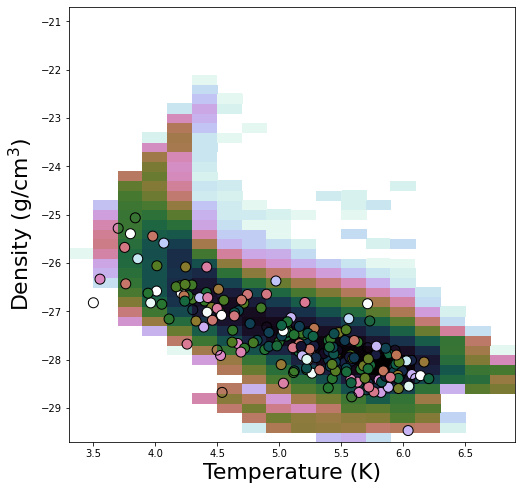

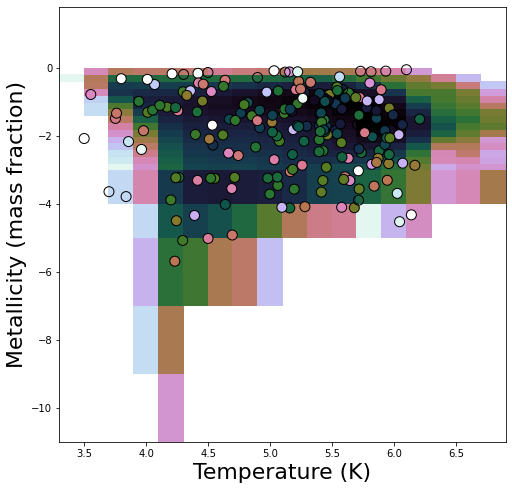

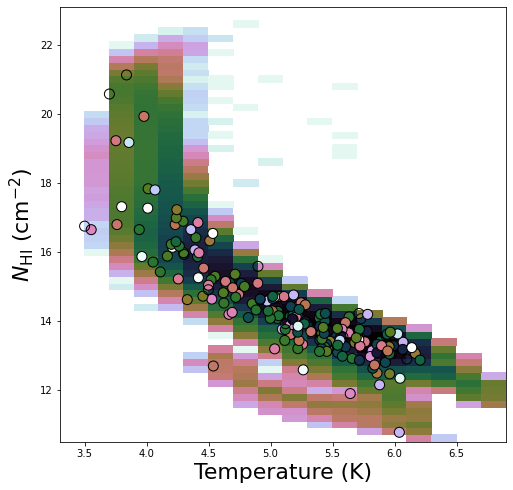

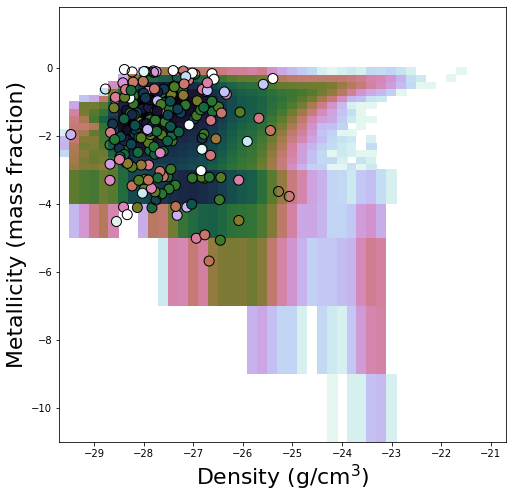

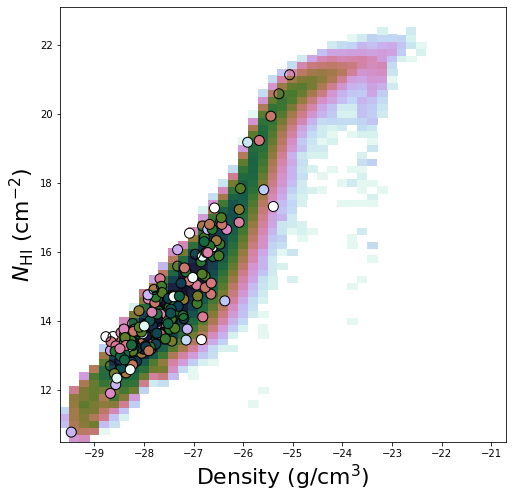

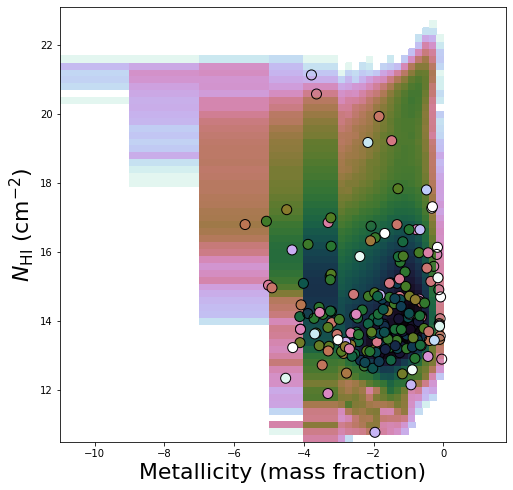

In [19]:
labels = [ 'Temperature (K)', r'Density (g/cm$^{3}$)', 'Metallicity (mass fraction)', r'$N_{\rm HI}$ (cm$^{-2}$)' ]
for k, (i, j) in enumerate( combinations ):
    
    # Show data
    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    sum_axes = copy.copy( list( inds ) )
    sum_axes.remove( i )
    sum_axes.remove( j )
    projection = pdf.sum( axis=tuple( sum_axes ) ).transpose()
    x, y = np.meshgrid( centers[i], centers[j] )
    ax.pcolormesh(
        centers[i],
        centers[j],
        np.log10( projection ),
        cmap = 'cubehelix_r',
    )
    
    ax.scatter(
        clouds[param_labels[i]],
        clouds[param_labels[j]],
        edgecolor = 'k',
        s = 100,
        c = clouds['PDF Value'],
        vmin = np.nanmin( pdf[np.nonzero(pdf)] ),
        vmax = np.nanmax( pdf[np.nonzero(pdf)] ),
        cmap = palettable.cubehelix.classic_16_r.mpl_colormap,
        norm = matplotlib.colors.LogNorm(),
    )

    
    ax.set_xlabel( labels[i], fontsize=22 )
    ax.set_ylabel( labels[j], fontsize=22 )
    
    ax.set_aspect( 'auto' )

# Create Spectra

In [26]:
i = 0

In [27]:
density = 10.**sls['Density'][i] * u.g / u.cm**-2
temperature = 10.**sls['Temperature'][i] * u.K
metallicity = 10.**sls['Metallicity'][i] * u.Zsun / 0.014
test_ds = trident.make_onezone_dataset(
    density = density[0],
    temperature = temperature[0],
    metallicity = metallicity[0],
    domain_width = 1.*u.kpc
)

yt : [INFO     ] 2021-02-18 16:46:11,437 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-02-18 16:46:11,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-18 16:46:11,438 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-02-18 16:46:11,439 Parameters: domain_right_edge         = [3.08567758e+21 3.08567758e+21 3.08567758e+21]
yt : [INFO     ] 2021-02-18 16:46:11,439 Parameters: cosmological_simulation   = 0.0


In [28]:
metallicity

unyt_array([0.00035059, 0.20377967, 0.15296903], '1/Zsun')

In [37]:
( bins[2] / 0.014 )

array([-8.57142857e+02, -7.14285714e+02, -5.71428571e+02, -4.28571429e+02,
       -3.57142857e+02, -2.85714286e+02, -2.71428571e+02, -2.57142857e+02,
       -2.42857143e+02, -2.28571429e+02, -2.14285714e+02, -2.00000000e+02,
       -1.85714286e+02, -1.71428571e+02, -1.57142857e+02, -1.42857143e+02,
       -1.28571429e+02, -1.14285714e+02, -1.00000000e+02, -8.57142857e+01,
       -7.14285714e+01, -5.71428571e+01, -4.28571429e+01, -2.85714286e+01,
       -1.42857143e+01,  2.53765263e-13,  1.42857143e+01,  2.85714286e+01,
        4.28571429e+01,  5.71428571e+01,             inf])